In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('adult.data', sep=",", header=None)
data.columns = ["age","workclass","fnlwgt","education","education-num","marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country","income"]
data = data.replace(' ','', regex=True)
data_continuous = data.iloc[:,[0,2,4,10,11,12]]
data_categorical = data.iloc[:,[1,3,5,6,7,8,9,13,14]]
data_dummies = pd.get_dummies(data_categorical)
data_dummies = data_dummies.drop(['sex_Female', 'income_<=50K'], axis=1)

cols = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
d_s=StandardScaler()
d_n=d_s.fit_transform(data_continuous)

In [3]:
# check if it came out correctly
print(data_dummies)

       workclass_?  workclass_Federal-gov  workclass_Local-gov  \
0                0                      0                    0   
1                0                      0                    0   
2                0                      0                    0   
3                0                      0                    0   
4                0                      0                    0   
5                0                      0                    0   
6                0                      0                    0   
7                0                      0                    0   
8                0                      0                    0   
9                0                      0                    0   
10               0                      0                    0   
11               0                      0                    0   
12               0                      0                    0   
13               0                      0                    0   
14        

In [4]:
# Preprocessing the data more

X_and_Y = np.hstack([d_n, data_dummies.values])
print(X_and_Y)
np.random.shuffle(X_and_Y)

# Let's use income >50k = 1 and income <= 50k = 0
# also sex_Male = 1 and sex_Female = 0
# So we omit second to last column
# cut out 64 and 65
X = X_and_Y[:5000, 0:-1]
Y = X_and_Y[:5000, -1]
print(X.shape, Y.shape)

[[ 0.03067056 -1.06361075  1.13473876 ...,  0.          0.          0.        ]
 [ 0.83710898 -1.008707    1.13473876 ...,  0.          0.          0.        ]
 [-0.04264203  0.2450785  -0.42005962 ...,  0.          0.          0.        ]
 ..., 
 [ 1.42360965 -0.35877741 -0.42005962 ...,  0.          0.          0.        ]
 [-1.21564337  0.11095988 -0.42005962 ...,  0.          0.          0.        ]
 [ 0.98373415  0.92989258 -0.42005962 ...,  0.          0.          1.        ]]
(5000, 107) (5000,)


In [5]:
X_train_val = X[:int(0.5*len(X))]
X_test      = X[int(0.5*len(X)):]
Y_train_val = Y[:int(0.5*len(Y))]
Y_test      = Y[int(0.5*len(Y)):]
print(X_train_val.shape, X_test.shape, Y_train_val.shape, Y_test.shape)

(2500, 107) (2500, 107) (2500,) (2500,)


In [6]:
# SVM process

# linear
# polynomial degree 2 & 3 (this one is using 3)
# radial with width [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
# regularization parameter C = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]

classifier = svm.SVC(kernel='linear')
C_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0, 1e1, 1e2, 1e3]   
params = {"C": C_list}

GSR = GridSearchCV(classifier, params, return_train_score=True, cv=5, n_jobs=4)
GSR.fit(X_train_val,Y_train_val)
GSR.cv_results_
                               
# May also want to try rbf kernel with sigma (radial width values)

{'mean_fit_time': array([  0.31572371,   0.36475778,   0.47940168,   0.34894629,
          0.31752462,   0.30771708,   0.28531842,   0.39250355,
          0.87132072,   5.79936171,  53.49636421]),
 'mean_score_time': array([ 0.06694846,  0.07495432,  0.06984978,  0.06534648,  0.06677237,
         0.06094384,  0.04923444,  0.04593229,  0.04353118,  0.04563274,
         0.04483237]),
 'mean_test_score': array([ 0.746 ,  0.746 ,  0.746 ,  0.746 ,  0.7536,  0.8356,  0.8484,
         0.838 ,  0.8384,  0.8368,  0.8372]),
 'mean_train_score': array([ 0.746 ,  0.746 ,  0.746 ,  0.746 ,  0.7536,  0.8412,  0.8583,
         0.863 ,  0.8633,  0.8637,  0.8637]),
 'param_C': masked_array(data = [1e-07 1e-06 1e-05 0.0001 0.001 0.01 0.1 1.0 10.0 100.0 1000.0],
              mask = [False False False False False False False False False False False],
        fill_value = ?),
 'params': ({'C': 1e-07},
  {'C': 1e-06},
  {'C': 1e-05},
  {'C': 0.0001},
  {'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1.

In [7]:
# find best C and best accuracy
test_acc = sum(GSR.best_estimator_.predict(X_test) == Y_test) / len(X_test)
print(GSR.best_params_)
print(test_acc)

{'C': 0.1}
0.8516


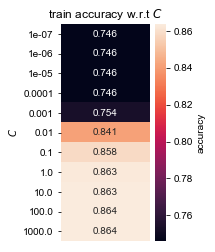

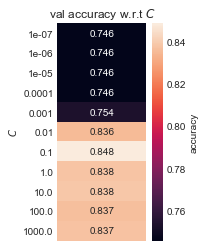

In [8]:
def draw_heatmap_linear(acc, acc_desc, C_list):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=C_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='$C$')
    plt.title(acc_desc + ' w.r.t $C$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    
results = GSR.cv_results_

train_acc = np.matrix(results.get("mean_train_score")).T
draw_heatmap_linear(train_acc, 'train accuracy', C_list)

val_acc = np.matrix(results.get("mean_test_score")).T
draw_heatmap_linear(val_acc, 'val accuracy', C_list)

In [9]:
def convert_to_gamma(radial_width):
    converted = [0]*len(radial_width)
    for i in range(len(radial_width)):
        gamma = 1/(2*(radial_width[i]**2))
        converted[i] = gamma
    return converted

In [10]:
radial_width = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
gamma_list = convert_to_gamma(radial_width)
print(gamma_list)

[500000.0, 20000.0, 5000.0, 199.99999999999997, 49.99999999999999, 2.0, 0.5, 0.125]


In [11]:
# SVM process

# rbf
# polynomial degree 2 & 3 (this one is using 3)
# radial with width [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
# regularization parameter C = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]

classifier = svm.SVC(kernel='rbf')
C_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0, 1e1, 1e2, 1e3]
params = {"C": C_list, "gamma": gamma_list}

GSR = GridSearchCV(classifier, params, return_train_score=True, cv=5, n_jobs=4)
GSR.fit(X_train_val,Y_train_val)
GSR.cv_results_
                               
# May also want to try rbf kernel with sigma (radial width values)

{'mean_fit_time': array([ 0.51616225,  0.63825083,  0.54762139,  0.49716911,  0.81760964,
         0.4201159 ,  0.44281363,  0.38777356,  0.49675126,  0.54359155,
         0.57834439,  0.6205616 ,  0.92597318,  0.5729094 ,  0.51788425,
         0.48324995,  0.50826964,  0.55320716,  0.53756318,  0.49265113,
         0.77989411,  0.43568406,  0.66553659,  0.55243769,  0.4807797 ,
         0.50786176,  0.6098321 ,  0.6621592 ,  0.90545754,  0.5284802 ,
         0.44502273,  0.48405747,  0.75083079,  0.84992871,  0.91687164,
         0.77895031,  1.14825149,  0.43171573,  0.44051118,  0.41920357,
         0.91201305,  1.00697379,  1.13228555,  1.27094831,  1.47177057,
         0.79853544,  0.71894503,  0.48955994,  1.00401335,  1.12654734,
         1.0437685 ,  0.89514298,  1.3947938 ,  0.81769814,  0.85362773,
         0.43627391,  0.92128954,  0.9928812 ,  0.93011708,  0.94407578,
         1.43361273,  0.80257168,  0.73742161,  0.38667336,  0.92027583,
         0.96976719,  0.97861438, 

In [12]:
# find best C and best accuracy
test_acc = sum(GSR.best_estimator_.predict(X_test) == Y_test) / len(X_test)
print(GSR.best_params_)
print(test_acc)

{'C': 1.0, 'gamma': 0.125}
0.8548


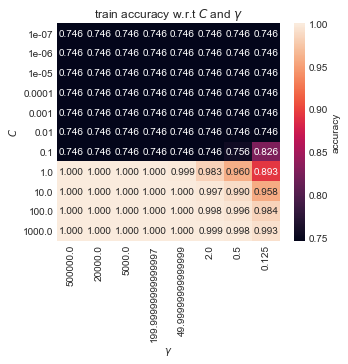

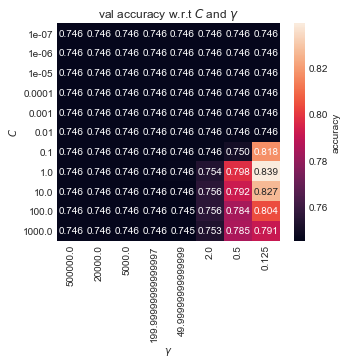

In [13]:
def draw_heatmap_RBF(acc, acc_desc, gamma_list, C_list):
    plt.figure(figsize = (5,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', 
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = '$\gamma$', ylabel='$C$')
    plt.title(acc_desc + ' w.r.t $C$ and $\gamma$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()   

train_acc = GSR.cv_results_['mean_train_score'].reshape(11,8)
draw_heatmap_RBF(train_acc, 'train accuracy', gamma_list, C_list)

val_acc = GSR.cv_results_['mean_test_score'].reshape(11,8)
draw_heatmap_RBF(val_acc, 'val accuracy',gamma_list, C_list)

In [12]:
# KNN
k_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]
#k_list = [1,5,8]
params = {"n_neighbors": k_list}
knn = KNeighborsClassifier(n_neighbors=26)
kgs=GridSearchCV(knn, params)
knn.fit(X_train_val, Y_train_val)
knn.predict(X_test)

array([ 0.,  0.,  1., ...,  0.,  0.,  0.])

In [13]:
# compute accuracy
test_acc = np.sum(knn.predict(X_test)==Y_test) / len(X_test)
print(test_acc)

0.8192


In [14]:
# Random Forest
rf = RandomForestClassifier(n_estimators=1024, random_state=0)
rf.fit(X_train_val, Y_train_val)
rf.predict(X_test)

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [15]:
# compute accuracy
test_acc = np.sum(rf.predict(X_test)==Y_test) / len(X_test)
print(test_acc)

0.8376
